In [48]:
import torch
import pyro
import pyro.distributions as p
from pyro import infer, optim
import random
import matplotlib.pyplot as plt

Lets generate some simple data first <br>
I just generate some coinflips from a biased coin

In [68]:
def generate_flips(n, prob=[0.8]):
    flips = p.Bernoulli(torch.tensor(prob)).expand([n]).sample()
    return flips

flips = generate_flips(1000)

Now lets make an easy generative model for the coin flips where <br>
we assume a normal prior on the bernouilli distribution

In [109]:
def model(data=None):
    # we initially assume 0.5 and 1 and this is only used for initialization and 
    # overwritten by the guide later
    bernouilli_param = pyro.sample('bernouilli', p.Normal(0.5, 1))
    
    # now we generate the coinflips and compare 
    # the plate gives us conditionally independence what we ofcourse want
    # since the flips should be conditionally independence given the bernouilli value
    for i in pyro.plate('flips', len(data)):
        # sample a flip
        pyro.sample(f'flip{i}', p.Bernoulli(bernouilli_param), obs=data[i])

# now the guide only generates the bernouilli params
def guide(data=None):
    mean_p = pyro.param('bernouilli_mean', 0.5*torch.ones([1]))
    sigma_p = pyro.param('bernouilli_sigma', torch.ones([1]))
    
    bern_param = pyro.sample('bernouilli', p.Normal(mean_p, sigma_p))
    return mean_p, sigma_p
    
        

In [123]:
# set up the optimizer
adam_params = {"lr": 0.001 }
optimizer = optim.RMSprop(adam_params)

# setup the inference algorithm
svi = infer.SVI(model, guide, optimizer, loss=infer.Trace_ELBO())

pyro.clear_param_store()

n_steps = 5000
losses = []
mus = []
sigs = []
# do gradient steps
for step in range(n_steps):
    losses.append(svi.step(flips))
    mus.append(float(pyro.get_param_store()['bernouilli_mean']))
    sigs.append(float(pyro.get_param_store()['bernouilli_sigma']))
    if random.random() > 0.9:
        print(f'loss: {losses[-1]}')

loss: 2197.5549278855324
loss: 1855.363404393196
loss: 957.2724600583315
loss: 3347.948424935341
loss: 12594.498973488808
loss: 622.0399901270866
loss: 2135.685126185417
loss: 12594.328973054886
loss: 12594.297994375229
loss: 3347.8552939891815
loss: 3347.9571293592453
loss: 556.6269346773624
loss: 3347.903393507004
loss: 3347.9361395835876
loss: 3347.943234682083
loss: 3347.985956788063
loss: 552.9214105308056
loss: 1557.2644434571266
loss: 1524.150954425335
loss: 3347.700672149658
loss: 534.4797449707985
loss: 3347.9545035362244
loss: 12594.27703499794
loss: 1257.9871889650822
loss: 1040.5153955817223
loss: 12594.46401488781
loss: 12594.309126019478
loss: 3347.9938185214996
loss: 1427.9917266070843
loss: 12594.106095075607
loss: 1054.5577183365822
loss: 12594.525508522987
loss: 564.6139511913061
loss: 653.9330125451088
loss: 12593.688488721848
loss: 964.01296043396
loss: 3347.7163321971893
loss: 3347.8880660533905
loss: 668.0729481577873
loss: 833.0504856817424
loss: 12593.5319244861

loss: 662.3880307674408
loss: 688.5650331526995
loss: 3348.728027701378
loss: 3348.247880101204
loss: 3348.7330382466316
loss: 3348.7398859858513
loss: 3348.752481877804
loss: 686.3979365304112
loss: 643.0577923059464
loss: 3348.6333545446396
loss: 548.2360314130783
loss: 553.1783204823732
loss: 549.7679333537817
loss: 3348.342115163803
loss: 12592.231876015663
loss: 12592.611662983894
loss: 612.3298346698284
loss: 3348.766248881817
loss: 617.6423979997635
loss: 1101.3680127859116
loss: 3347.677226305008
loss: 555.6444365829229
loss: 564.4901016950607
loss: 3346.1929327249527
loss: 3347.769907474518
loss: 551.3266015201807
loss: 593.3886939883232
loss: 572.4417049884796
loss: 3348.7214758992195
loss: 1592.5287363231182
loss: 540.8277308642864
loss: 1446.528633594513
loss: 890.8104237318039
loss: 593.3533705472946
loss: 640.0734574794769
loss: 663.1373291015625
loss: 3348.8149181604385
loss: 1050.8186721205711
loss: 12591.714839339256
loss: 554.8965037465096
loss: 1151.4725244641304
los

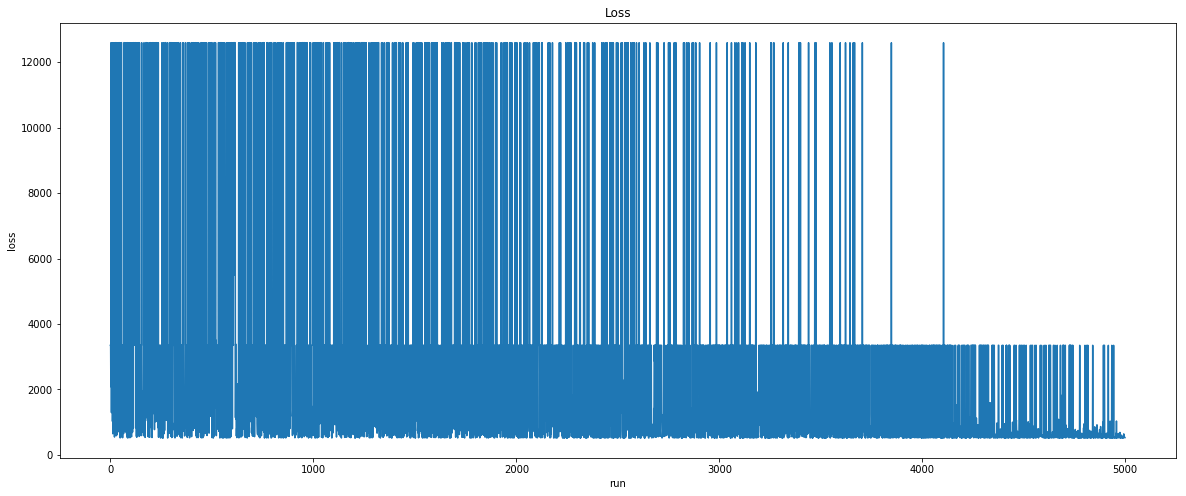

In [124]:
plt.figure(figsize=(20,8))
plt.title('Loss')
plt.plot(list(range(len(losses))), losses)
plt.ylabel('loss')
plt.xlabel('run')

plt.show()

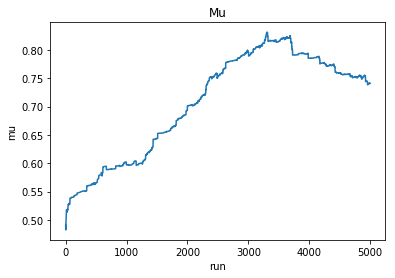

In [125]:
plt.title('Mu')
plt.plot(list(range(len(mus))), mus)
plt.ylabel('mu')
plt.xlabel('run')
plt.show()

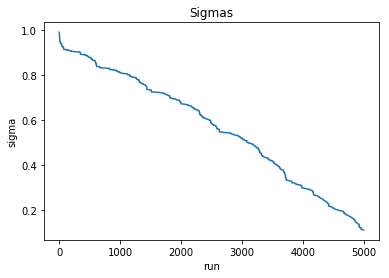

In [126]:
plt.title('Sigmas')
plt.plot(list(range(len(sigs))), sigs)
plt.ylabel('sigma')
plt.xlabel('run')
plt.show()